In [1]:
%pylab inline
import scipy
import time
plt.rc("text", usetex=True)
plt.rc("font", family="Serif")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
CE_PSD = np.genfromtxt("./cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("./gamma_HL.txt")

In [24]:
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100
class Simulator():
    def __init__(self, Omega_ref, alpha, fref, psd, gamma, T_obs):
        self.Omega_ref = Omega_ref
        self.alpha     = alpha
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs

        
    def psd_interp(self, f):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(f)
    
    def gamma_interp(self, f):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(f)
    
    def C_ij(self, f):
        T = 1/(f[1]-f[0])
        C_hat_ij = self.Omega_ref * (f/self.fref)**self.alpha
        N = 2*self.T_obs / T - 1
        sigma = np.sqrt(self.var(f)/N)
        return C_hat_ij + np.random.normal(0, sigma)
    def groundtruth(self, f):
        return self.Omega_ref * (f/self.fref)**self.alpha
    def var(self, f):
        numerator = (20*pi**2*f**3)**2 * self.psd_interp(f)**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp(f)**2
        return numerator/denomenator

## 
$$\Omega_\mathrm{GW}(f)=\frac{1}{\rho_c}\frac{\mathrm{d}\rho_\mathrm{GW}}{\mathrm{d}\ln f}$$
$$\Omega_\mathrm{GW}(f)=\Omega_\mathrm{ref}\Big(\frac{f}{f_\mathrm{ref}}\Big)^\alpha$$

In [27]:
Omega_ref = 1e-10
alpha = 2/3

fref = 25
T_obs = 365 * 24 * 3600
f = np.arange(5.00,1024,1/4)
simulator = Simulator(Omega_ref, alpha, fref, CE_PSD, gamma_HL, T_obs)

Text(0, 0.5, '$\\Omega_\\mathrm{GW}(f)$')

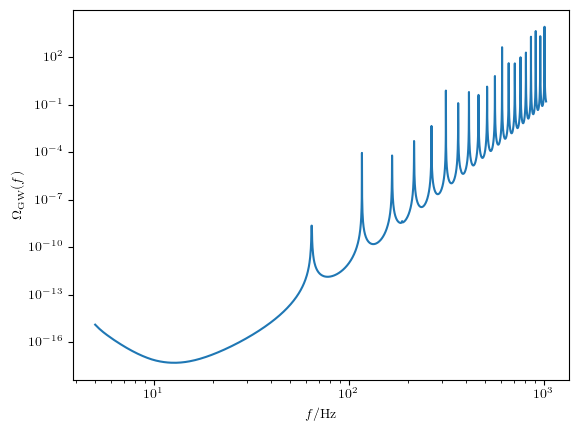

In [28]:
plt.loglog(f, simulator.var(f))
plt.xlabel(r"$f/$Hz")
plt.ylabel(r"$\Omega_\mathrm{GW}(f)$")

In [29]:
theta = [1e-11, 2./3]
C_IJ = simulator.C_ij(f)
groundtruth = simulator.groundtruth(f)
sigma_IJ = np.sqrt(simulator.var(f))
np.save("training_data",{'theta':theta,'C_IJ':C_IJ, 'sigma_IJ':sigma_IJ})

Text(0, 0.5, '$C_\\mathrm{IJ}(f)$')

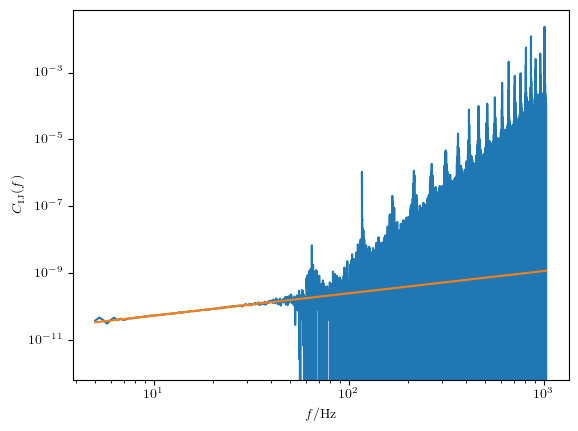

In [30]:
plt.loglog(f, C_IJ, label="noisy data")
plt.loglog(f, groundtruth, label="ground truth")
plt.xlabel(r"$f/$Hz")
plt.ylabel(r"$C_\mathrm{IJ}(f)$")

(-1e-10, 1e-10)

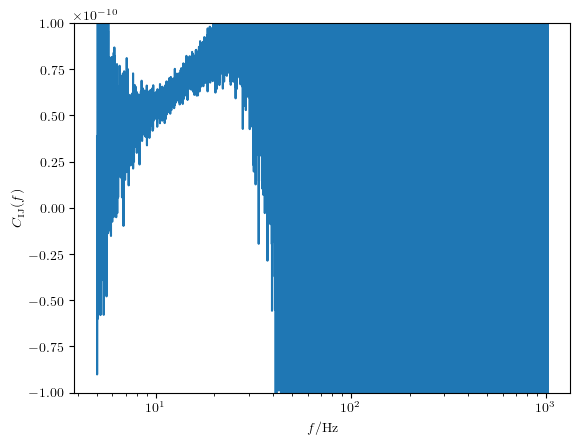

In [23]:
plt.semilogx(f, simulator.C_ij(f))
plt.xlabel(r"$f/$Hz")
plt.ylabel(r"$C_\mathrm{IJ}(f)$")
plt.ylim(-1e-10,1e-10)

# Piecewise

In [133]:
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100
class Simulator():
    def __init__(self, Omega_ref, f_ref, alpha, Omega_pivot, f_pivot, alpha_list, psd, gamma, T_obs):
        self.Omega_ref      = Omega_ref
        self.f_ref          = f_ref
        self.alpha          = alpha
        self.Omega_pivot    = Omega_pivot
        self.f_pivot        = f_pivot
        self.alpha_list     = alpha_list
        self.psd            = psd
        self.gamma          = gamma
        self.T_obs          = T_obs

        
    def psd_interp(self, f):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(f)
    
    def gamma_interp(self, f):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(f)
    
    def Omega_piecewise(self, f):
        Omega = np.zeros(len(f))
        for ix, f_p in enumerate(self.f_pivot):
            if ix == 0:  
                continue
            idx = ((f>=self.f_pivot[ix-1]) & (f<=f_p))
            if ix == 1:
                Omega[idx] = self.Omega_pivot*(f[idx]/self.f_pivot[ix-1])**self.alpha_list[ix-1]
            elif ix > 1:
                previous_id = np.argmax(idx)-1
                Omega[idx] = Omega[previous_id]*(f[idx]/self.f_pivot[ix-1])**self.alpha_list[ix-1]
        return Omega
    
    def Omega_CGWB(self, f):
        return self.Omega_ref*(f/self.f_ref)**self.alpha
    
    def C_ij(self,  f):
        T = 1/(f[1]-f[0])
        C_hat_ij = self.Omega_piecewise(f) + self.Omega_CGWB(f)
        N = 2*self.T_obs / T - 1
        sigma = np.sqrt(self.var(f)/N)
        return C_hat_ij + np.random.normal(0, sigma)
    

    def var(self, f):
        numerator = (20*pi**2*f**3)**2 * self.psd_interp(f)**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp(f)**2
        return numerator/denomenator

In [134]:
f_ref = 25
alpha = 0
Omega_ref = 4e-11

num_piv = 50
Omega_pivot = 1e-10
alpha_list = (np.random.random(num_piv)-0.5)*6

f_pivot = np.logspace(1,3,num_piv)
T_obs = 365 * 24 * 3600
f = np.arange(10,1000.25,0.25)
simulator = Simulator(Omega_ref, f_ref, alpha, Omega_pivot, f_pivot, alpha_list, CE_PSD, gamma_HL, T_obs)

Text(0, 0.5, '$\\Omega_\\mathrm{GW}(f)$')

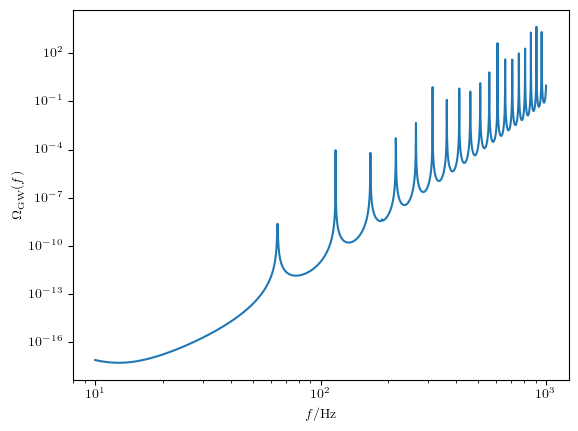

In [126]:
plt.loglog(f, simulator.var(f))
plt.xlabel(r"$f/$Hz")
plt.ylabel(r"$\Omega_\mathrm{GW}(f)$")

In [135]:
C_IJ = simulator.C_ij(f)
Omega_res = simulator.Omega_piecewise(f)
Omega_CGWB = simulator.Omega_CGWB(f)
sigma_IJ = np.sqrt(simulator.var(f))
#np.save("training_data",{'theta':theta,'C_IJ':C_IJ, 'sigma_IJ':sigma_IJ})

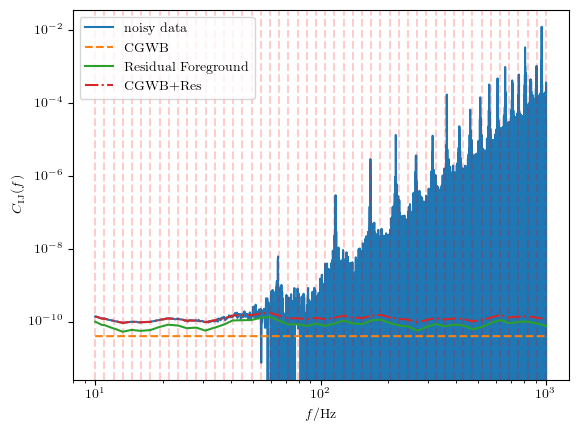

In [138]:
plt.loglog(f, C_IJ, label="noisy data")
for i in range(len(f_pivot)):
    plt.axvline(f_pivot[i],color="red",linestyle="--",alpha=0.2)
plt.loglog(f, Omega_CGWB, "--", label="CGWB")
plt.loglog(f, Omega_res, "-", label="Residual Foreground")
plt.loglog(f, Omega_CGWB+Omega_res, "-.", label="CGWB+Res")
plt.xlabel(r"$f/$Hz")
plt.ylabel(r"$C_\mathrm{IJ}(f)$")
plt.legend()